In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl

mpl.rc("mathtext", fontset="cm")
#plt.rcParams.update({"font.size": 14})
# plt.rcParams["image.cmap"] = "twilight"

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

In [4]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from nuq.nuq_classifier_exact import NUQClassifierExact

In [5]:
## Make a dataset
X, y = make_moons(
    n_samples=500,  # total_size=10_000,
    noise=0.2,
    random_state=42,
)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

In [6]:
# Get embeddings from sklearn
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.utils.extmath import safe_sparse_dot


def get_embeddings(model, X):

    """Predict using the trained model
    This is the same as _forward_pass but does not record the activations
    of all layers and only returns the last layer's activation.
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The input data.
    Returns
    -------
    y_pred : ndarray of shape (n_samples,) or (n_samples, n_outputs)
        The decision function of the samples for each class in the model.
    """
    #X = model._validate_data(X, accept_sparse=["csr", "csc"], reset=False)

    # Initialize first layer
    activation = X

    # Forward propagate
    hidden_activation = ACTIVATIONS[model.activation]
    for i in range(model.n_layers_ - 2):
        activation = safe_sparse_dot(activation, model.coefs_[i])
        activation += model.intercepts_[i]
        if i != model.n_layers_ - 2:
            hidden_activation(activation)
    # output_activation = ACTIVATIONS[self.out_activation_]
    # output_activation(activation)

    return activation

In [7]:
nn_sizes = (10, 10)
activation = 'relu'

nn_desc = (nn_sizes, activation)

model = MLPClassifier(hidden_layer_sizes=nn_sizes, activation=activation) #, alpha=0.001)

model.fit(X_train_nn, y_train_nn)

X_train = get_embeddings(model, X_train_nn)
y_train = y_train_nn

X_val = get_embeddings(model, X_val_nn)
y_val = y_val_nn

print(X_train.shape, X_val.shape)

(400, 10) (100, 10)


/home/alex/anaconda3/envs/ray-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
import torch
import numpy as np

DOUBLE_INFO = torch.finfo(torch.double)
JITTERS = [0, DOUBLE_INFO.tiny] + [10**exp for exp in range(-10, 0, 1)]


def centered_cov(x):
    return x.T @ x / (len(x) - 1)


def compute_density(log_logits, label_probs):
    return torch.sum((torch.exp(log_logits / 2) * label_probs[label_probs > 0]), dim=1)


def get_gmm_log_probs(gaussians_model, embeddings):
    return gaussians_model.log_prob(embeddings[:, None, :])


def gmm_fit(embeddings, labels):
    num_classes = len(set(labels))
    with torch.no_grad():
        centroids = torch.stack(
            [torch.mean(embeddings[labels == c], dim=0) for c in range(num_classes)]
        )
        cov_matrix = torch.stack(
            [
                centered_cov(embeddings[labels == c] - centroids[c])
                for c in range(num_classes)
            ]
        )

    with torch.no_grad():
        for jitter_eps in JITTERS:
            try:
                jitter = jitter_eps * torch.eye(
                    cov_matrix.shape[1],
                    device=cov_matrix.device,
                ).unsqueeze(0)
                gmm = torch.distributions.MultivariateNormal(
                    loc=centroids,
                    covariance_matrix=(cov_matrix + jitter),
                )
                break
            except RuntimeError as e:
                if "cholesky" in str(e):
                    continue
            except ValueError as e:
                if "The parameter covariance_matrix has invalid values" in str(e):
                    continue
    return gmm, jitter_eps


In [9]:
def clip_to_min_max(x):
    z = x.copy()
    zmin = z[np.isfinite(z)].min()
    zmax = z[np.isfinite(z)].max()
    z[z == np.inf] = zmax
    z[z == -np.inf] = zmin

    z = np.clip(z, zmin, zmax) / zmax

    return z


In [10]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

In [11]:
h_x, h_y = [0.1] * 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
X_test = np.c_[xx.ravel(), yy.ravel()]
X_test_emb = get_embeddings(model, X_test)
print(f"{X_test.shape = }, {X_test_emb.shape = }")

X_test.shape = (2700, 2), X_test_emb.shape = (2700, 10)


In [12]:
from sklearn.model_selection import GridSearchCV

nuq_base = NUQClassifierExact()
param_grid = {"bandwidth": np.linspace(0.1, 5.0, 50)}

search = GridSearchCV(nuq_base, param_grid, cv=40)
res = search.fit(X_train, y_train)
df = pd.DataFrame(search.cv_results_)
print(f"{search.best_params_=}")

h_best = search.best_params_["bandwidth"]

search.best_params_={'bandwidth': 3.8000000000000003}


### NUQ predictions

In [13]:
#eta_hat, tau = nuq_predict(X_train, y_train, X_test_emb, h=h_best)

#uncertainty_total = np.c_[eta_hat, 1 - eta_hat].min(axis=-1) + 2 * np.sqrt(2 / np.pi) * tau

nuq_clf = NUQClassifierExact(bandwidth=h_best)
nuq_clf.fit(X_train, y_train)
eta_hat, u1, u2, u3 = nuq_clf.predict_proba(X_test_emb)

nuq_unc_total = u3

### DDU predictions

In [14]:
# DDU predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_torch = torch.Tensor(X_train).to(device)

gmm, jitter = gmm_fit(X_train_torch, y_train)
label_probs = torch.Tensor(np.bincount(y_train) / len(y_train)).to(device)

X_test_torch = torch.Tensor(X_test_emb).to(device)

log_probs = get_gmm_log_probs(gmm, X_test_torch)
scores = compute_density(log_probs, label_probs)

ddu_probs = torch.exp(log_probs).detach().cpu().numpy()
ddu_uncertainty = clip_to_min_max(scores.detach().cpu().numpy())


/tmp/ipykernel_1936290/4236207920.py:34: RuntimeWarning: divide by zero encountered in log
  ax[4].contourf(xx, yy, np.log(nuq_unc_total.reshape(*xx.shape)), cmap="inferno")
/tmp/ipykernel_1936290/4236207920.py:47: RuntimeWarning: divide by zero encountered in log
  ax[7].contourf(xx, yy, np.log(ddu_uncertainty.reshape(*xx.shape)), cmap="inferno")


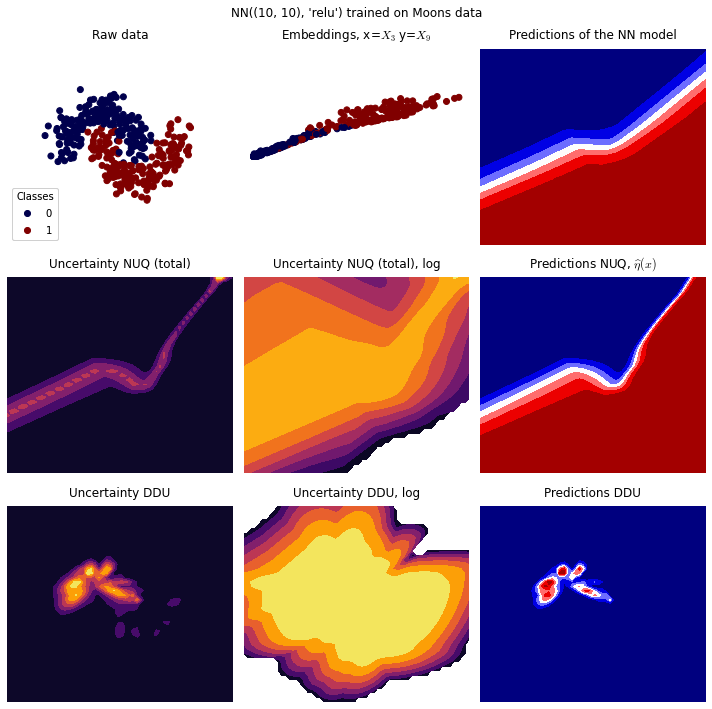

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharey=True)

fig.suptitle(f"NN{nn_desc} trained on Moons data")

ax = ax.ravel()

for axis in ax:
    axis.axis("off")
ax[0].set_title("Raw data")
scatter0 = ax[0].scatter(X_train_nn[:, 0], X_train_nn[:, 1], c=y_train, cmap="seismic")
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)

legend0 = ax[0].legend(*scatter0.legend_elements(),
                    loc="lower left", title="Classes")
ax[0].add_artist(legend0)

i, j = np.random.choice(X_train.shape[1], size=2, replace=False)
ax[1].set_title(rf"Embeddings, x=$X_{{{i}}}$ y=$X_{{{j}}}$")
ax[1].scatter(X_train[:, i], X_train[:, j], c=y_train, cmap="seismic")
# ax[2].set_xlim(x_min, x_max)
# ax[2].set_ylim(y_min, y_max)

nn_pred = model.predict_proba(X_test)
ax[2].set_title("Predictions of the NN model")
ax[2].contourf(xx, yy, nn_pred[:, 1].reshape(*xx.shape), cmap="seismic")

# NUQ

ax[5].set_title(r"Predictions NUQ, $\widehat{\eta}(x)$")
ax[5].contourf(xx, yy, eta_hat.reshape(*xx.shape), cmap="seismic")

ax[4].set_title(f"Uncertainty NUQ (total), log")
ax[4].contourf(xx, yy, np.log(nuq_unc_total.reshape(*xx.shape)), cmap="inferno")

ax[3].set_title(f"Uncertainty NUQ (total)")
ax[3].contourf(xx, yy, nuq_unc_total.reshape(*xx.shape), cmap="inferno")

# end NUQ

# DDU

ax[8].set_title(f"Predictions DDU")
ax[8].contourf(xx, yy, ddu_probs[:, 0].reshape(*xx.shape), cmap="seismic")

ax[7].set_title(f"Uncertainty DDU, log")
ax[7].contourf(xx, yy, np.log(ddu_uncertainty.reshape(*xx.shape)), cmap="inferno")

ax[6].set_title(f"Uncertainty DDU")
ax[6].contourf(xx, yy, ddu_uncertainty.reshape(*xx.shape), cmap="inferno")

# end DDU

plt.tight_layout()
plt.show()